In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Colab Notebooks/Data Science/bank_amazon

%pip install seaborn
%pip install matplotlib

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix, classification_report, roc_curve, auc
import warnings

warnings.filterwarnings('ignore')
sns.set(font_scale=1.8)

df = pd.read_csv('./BankCustomerData.csv')

#print(df)

#---data preparation-----------------------------------------------------------#

#Togliamo le colonne string
#df = dfTot[['age','balance','day','duration','campaign','pdays','previous']]

#OPPURE

#Convertimo i parametri string ad interi
#df = dfTot
df['job']=df['job'].astype('category').cat.codes
df['marital']=df['marital'].astype('category').cat.codes
df['education']=df['education'].astype('category').cat.codes
df['default']=df['default'].astype('category').cat.codes
df['housing']=df['housing'].astype('category').cat.codes
df['loan']=df['loan'].astype('category').cat.codes
df['contact']=df['contact'].astype('category').cat.codes
df['month']=df['month'].astype('category').cat.codes
df['poutcome']=df['poutcome'].astype('category').cat.codes
df['term_deposit']=df['term_deposit'].astype('category').cat.codes

df.head(100)
#------------------------------------------------------------------------------#

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,term_deposit
0,58,4,1,2,0,2143,1,0,2,5,8,261,1,-1,0,3,0
1,44,9,2,1,0,29,1,0,2,5,8,151,1,-1,0,3,0
2,33,2,1,1,0,2,1,1,2,5,8,76,1,-1,0,3,0
3,47,1,1,3,0,1506,1,0,2,5,8,92,1,-1,0,3,0
4,33,11,2,3,0,1,0,0,2,5,8,198,1,-1,0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,36,4,1,2,0,101,1,1,2,5,8,426,1,-1,0,3,0
96,55,1,1,1,0,383,0,0,2,5,8,287,1,-1,0,3,0
97,60,5,1,2,0,81,1,0,2,5,8,101,1,-1,0,3,0
98,39,9,1,1,0,0,1,0,2,5,8,203,1,-1,0,3,0


In [ ]:
#@title BEFORE SAMPLING
#Random SEED (INTRODUCE UN FATTORE DI RANDOMICITA')
rs = 50

#Si divide il dataset in 80% train e 20% test
x = df.iloc[:,:-1] #feature per fare la predizione
y = df.iloc[:,-1:] #label da predirre (deposito a lungo termine si - no)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=rs)

# controllo sullo SHAPE degli array (es. il test deve essere sempre x:1 e il train x:16)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)


classifiers = [
    LogisticRegression(random_state = rs),
    DecisionTreeClassifier(random_state=rs),
    SVC(),
    RandomForestClassifier(n_estimators = 10, random_state=rs),
    AdaBoostClassifier(n_estimators=10, random_state=rs),
    GradientBoostingClassifier(n_estimators=10, random_state=rs),
    LinearDiscriminantAnalysis()
]


clf_name = [] #nomi classificatori
model_results = pd.DataFrame.copy(y_test) #array di predizioni fatte dai modelli

kfold = StratifiedKFold(n_splits=50) #cross-validation 
cv_results = [] # score cross validation
cv_acc = [] # accuracy cross validation
cv_std = [] # deviazione standard dalla cross validation

cnfm = [] #matrice di confusione
clr = [] #report di classificazione
roc_auc = [] #curva roc
roc_tpr = []
roc_fpr = []
print("\n")

#ALLENAMENTO MODELLI
for clf in classifiers:
    name = clf.__class__.__name__
    clf_name.append(name)
    
    #fitting and predictions
    model = clf.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    model_results[name] = y_pred
    
    #accuracy and log loss
    cv_results.append(cross_val_score(clf, x_train, y_train, scoring = "accuracy",cv = kfold))
    acc = round(accuracy_score(y_test, y_pred), 2) #need to maximize
    #train_pred = clf.predict_proba(x_test)
    print(f'Accuracy: {acc} \t ---> {name} ')
    
    #confusion matrix, clasification report, roc curve
    cnfm.append(confusion_matrix(y_test, y_pred))
    clr.append(classification_report(y_test, y_pred))
    fpr, tpr, thresholds = roc_curve(y_pred, y_test)
    roc_auc.append(auc(fpr, tpr))
    roc_tpr.append(tpr)
    roc_fpr.append(fpr)
    

for i in cv_results:
    cv_acc.append(i.mean())
    cv_std.append(i.std())


cv_res = pd.DataFrame({"CrossValMeans":cv_acc, "CrossValerrors": cv_std,"Algorithm":clf_name})

plt.figure(figsize=(12,6))
sns.barplot(x="CrossValMeans",y="Algorithm",data = cv_res, palette="Set2",orient = "h",**{'xerr':cv_std})
plt.xlabel("Accuracy media")
plt.title("Score di cross validation")

for i in range(len(classifiers)):
    print (f"{clf_name[i]} Report di classificazione:" )
    print (clr[i])

#CURVA ROC
plt.figure(figsize=(15,8))
for i in range(len(classifiers)):
    cm = ['red', 'blue', 'orange', 'green', 'pink', 'yellow', 'lightgreen', 'black', 'purple', 'lightblue'] #add more colours for more algorithms
    plt.plot(roc_fpr[i], roc_tpr[i], c=cm[i], lw=1, label=clf_name[i].replace("Classifier", "") + " (AUC = " + str(round(roc_auc[i],2)) + ")")
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlabel('FP')
    plt.ylabel('TP')
    plt.title('Curva ROC')
    plt.legend(loc="lower right")

In [ ]:
#----------Verification of class imbalance-------------------------------------#

df['term_deposit'].value_counts()
failed = len(df[df['term_deposit'] == 0])
done = len(df[df['term_deposit'] == 1])
class_distribution_ratio = done/failed
print(f"Class distribution before undersampling: {class_distribution_ratio}")
print(f"Nr true samples before undersampling: {done}\n")
#------------------------------------------------------------------------------#

#------------------SIMPLE RESAMPLING-------------------------------------------#

# Separate majority and minority classes
df_majority = df[df['term_deposit']==0]
df_minority = df[df['term_deposit']==1]

# Undersample majority class
df_majority_undersampled = resample(df_majority, 
                                 replace=True,     # sample with replacement
                                 n_samples=round(3*done),   # to match minority class
                                 random_state=100)  # reproducible results
 
# Combine majority class with undersampled majority class
df_undersampled = pd.concat([df_majority_undersampled, df_minority])

#------------------------------------------------------------------------------#

#------------------verification of undersampling--------------------------------#

failed = len(df_undersampled[df_undersampled['term_deposit'] == 0])
done = len(df_undersampled[df_undersampled['term_deposit'] == 1])
class_distribution_ratio = done/failed
print(f"Class distribution after undersampling: {class_distribution_ratio}")
print(f"Nr failed samples after undersampling: {failed}\n")
#------------------------------------------------------------------------------#

# Separate majority and minority classes
df_majority = df_undersampled[df_undersampled['term_deposit']==0]
df_minority = df_undersampled[df_undersampled['term_deposit']==1]

# Undersample majority class
df_minority_upsample = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=failed,   # to match minority class
                                 random_state=100)  # reproducible results
 
# Combine majority class with undersampled majority class
df_undersampled = pd.concat([df_majority, df_minority_upsample])

#------------------------------------------------------------------------------#

#------------------verification of undersampling--------------------------------#

failed = len(df_undersampled[df_undersampled['term_deposit'] == 0])
done = len(df_undersampled[df_undersampled['term_deposit'] == 1])
class_distribution_ratio = done/failed
print(f"Class distribution after oversampling: {class_distribution_ratio}")
print(f"Nr samples after sampling: {done+failed}\n")
#------------------------------------------------------------------------------#

Class distribution before undersampling: 0.10240963855421686
Nr true samples before undersampling: 3961

Class distribution after undersampling: 0.3333333333333333
Nr failed samples after undersampling: 11883

Class distribution after oversampling: 1.0
Nr samples after sampling: 23766



In [ ]:
#---Correlation matrix------
df=df_undersampled
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

#---------------------------

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,term_deposit
age,1.000000,-0.023478,-0.431882,-0.109598,-0.018215,0.104737,-0.186388,-0.033063,0.029374,-0.006194,-0.028882,-0.016616,-0.006163,-0.020009,-0.017315,0.029449,0.013797
job,-0.023478,1.000000,0.074794,0.151985,-0.005745,0.023727,-0.141883,-0.047937,-0.093697,0.019019,-0.087704,-0.009619,-0.004607,-0.040395,-0.005931,0.018983,0.049915
marital,-0.431882,0.074794,1.000000,0.113802,-0.009957,0.004468,-0.025217,-0.046393,-0.043528,-0.007575,-0.004099,0.013973,-0.003794,-0.004389,0.013038,-0.007679,0.060884
education,-0.109598,0.151985,0.113802,1.000000,-0.008994,0.088946,-0.114754,-0.065371,-0.116459,0.017789,-0.045053,-0.018449,-0.003494,-0.013524,0.007765,-0.018080,0.099281
default,-0.018215,-0.005745,-0.009957,-0.008994,1.000000,-0.063919,0.006231,0.069991,0.023042,0.000830,0.000539,-0.001363,0.016411,-0.021226,-0.026527,0.028492,-0.017498
balance,0.104737,0.023727,0.004468,0.088946,-0.063919,1.000000,-0.095274,-0.086333,-0.037219,0.002265,0.018012,0.010280,-0.024920,0.014624,0.023646,-0.026440,0.083995
housing,-0.186388,-0.141883,-0.025217,-0.114754,0.006231,-0.095274,1.000000,0.075661,0.220656,-0.013883,0.255184,0.051151,-0.002313,0.163636,0.061864,-0.121142,-0.178185
loan,-0.033063,-0.047937,-0.046393,-0.065371,0.069991,-0.086333,0.075661,1.000000,0.007338,0.014719,0.043410,0.022535,0.025809,0.000690,0.005206,0.004830,-0.082619
contact,0.029374,-0.093697,-0.043528,-0.116459,0.023042,-0.037219,0.220656,0.007338,1.000000,0.001887,0.324147,0.004331,0.048455,-0.219628,-0.154661,0.236409,-0.222705
day,-0.006194,0.019019,-0.007575,0.017789,0.000830,0.002265,-0.013883,0.014719,0.001887,1.000000,-0.028154,-0.007187,0.140012,-0.077289,-0.047585,0.060271,-0.041949


(19012, 16)
(4754, 16)
(19012, 1)
(4754, 1)


Accuracy: 0.78 	 ---> LogisticRegression 
Accuracy: 0.93 	 ---> DecisionTreeClassifier 
Accuracy: 0.72 	 ---> LinearSVC 
Accuracy: 0.95 	 ---> RandomForestClassifier 
Accuracy: 0.79 	 ---> AdaBoostClassifier 
Accuracy: 0.8 	 ---> GradientBoostingClassifier 
Accuracy: 0.8 	 ---> LinearDiscriminantAnalysis 
LogisticRegression Report di classificazione:
              precision    recall  f1-score   support

           0       0.75      0.82      0.78      2306
           1       0.81      0.74      0.77      2448

    accuracy                           0.78      4754
   macro avg       0.78      0.78      0.78      4754
weighted avg       0.78      0.78      0.78      4754

DecisionTreeClassifier Report di classificazione:
              precision    recall  f1-score   support

           0       0.96      0.90      0.93      2306
           1       0.91      0.97      0.94      2448

    accuracy                           0.93      4754
   mac

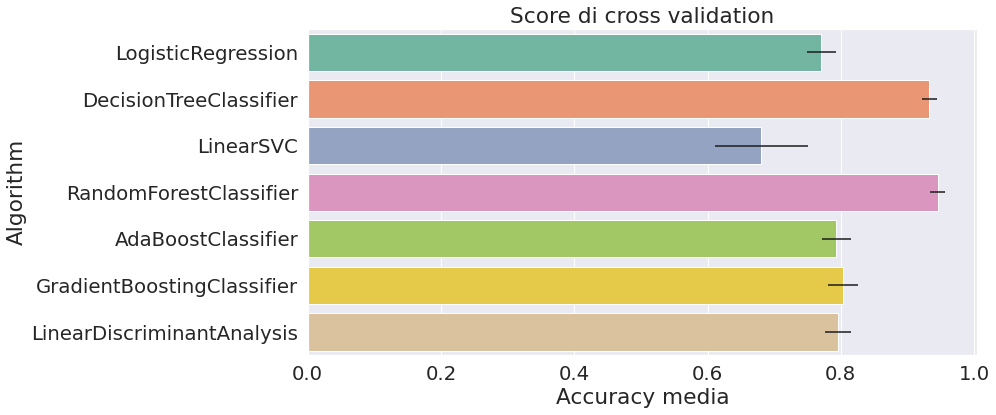

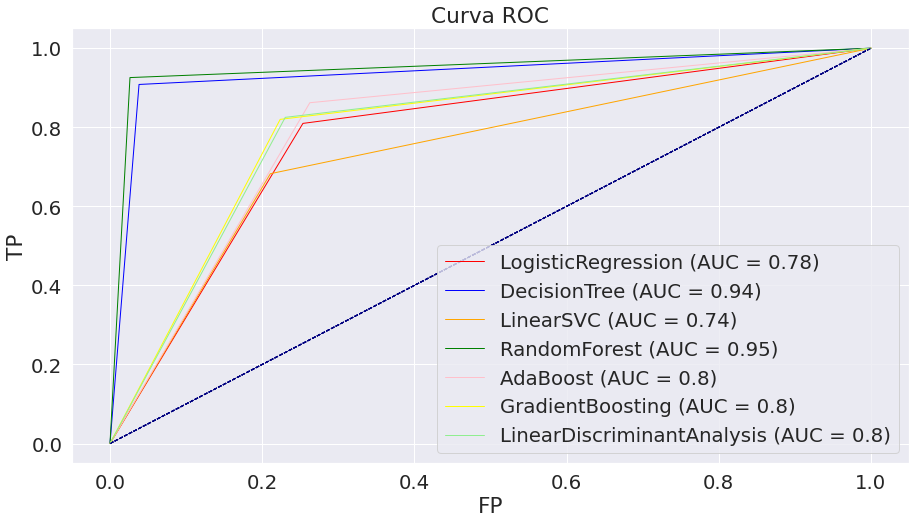

In [ ]:
#------------CLASSIFICATION MODELS--------------------------------------------#

# Random SEED (INTRODUCE UN FATTORE DI RANDOMICITA')
rs = 50

#Si divide il dataset in 80% train e 20% test
x = df.iloc[:,:-1] #feature per fare la predizione
y = df.iloc[:,-1:] #label da predirre (deposito a lungo termine si - no)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=rs)

# controllo sullo SHAPE degli array (es. il test deve essere sempre x:1 e il train x:16)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)


classifiers = [
    LogisticRegression(random_state = rs),
    DecisionTreeClassifier(random_state=rs),
    LinearSVC(random_state=rs),
    RandomForestClassifier(n_estimators = 10, random_state=rs),
    AdaBoostClassifier(n_estimators=10, random_state=rs),
    GradientBoostingClassifier(n_estimators=10, random_state=rs),
    LinearDiscriminantAnalysis()
]


clf_name = [] #nomi classificatori
model_results = pd.DataFrame.copy(y_test) #array di predizioni fatte dai modelli

kfold = StratifiedKFold(n_splits=50) #cross-validation 
cv_results = [] # score cross validation
cv_acc = [] # accuracy cross validation
cv_std = [] # deviazione standard dalla cross validation

cnfm = [] #matrice di confusione
clr = [] #report di classificazione
roc_auc = [] #curva roc
roc_tpr = []
roc_fpr = []
print("\n")
#------------------------------------------------------------------------------#

#--------------TRAINING AND RESULTS--------------------------------------------#

#ALLENAMENTO MODELLI
for clf in classifiers:
    name = clf.__class__.__name__
    clf_name.append(name)
    
    #fitting and predictions
    model = clf.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    model_results[name] = y_pred
    
    #accuracy and log loss
    cv_results.append(cross_val_score(clf, x_train, y_train, scoring = "accuracy",cv = kfold))
    acc = round(accuracy_score(y_test, y_pred), 2) #need to maximize
    #train_pred = clf.predict_proba(x_test)
    print(f'Accuracy: {acc} \t ---> {name} ')
    
    #confusion matrix, clasification report, roc curve
    cnfm.append(confusion_matrix(y_test, y_pred))
    clr.append(classification_report(y_test, y_pred))
    fpr, tpr, thresholds = roc_curve(y_pred, y_test)
    roc_auc.append(auc(fpr, tpr))
    roc_tpr.append(tpr)
    roc_fpr.append(fpr)
    

for i in cv_results:
    cv_acc.append(i.mean())
    cv_std.append(i.std())


cv_res = pd.DataFrame({"CrossValMeans":cv_acc, "CrossValerrors": cv_std,"Algorithm":clf_name})

plt.figure(figsize=(12,6))
sns.barplot(x="CrossValMeans",y="Algorithm",data = cv_res, palette="Set2",orient = "h",**{'xerr':cv_std})
plt.xlabel("Accuracy media")
plt.title("Score di cross validation")

for i in range(len(classifiers)):
    print (f"{clf_name[i]} Report di classificazione:" )
    print (clr[i])

#CURVA ROC
plt.figure(figsize=(15,8))
for i in range(len(classifiers)):
    cm = ['red', 'blue', 'orange', 'green', 'pink', 'yellow', 'lightgreen', 'black', 'purple', 'lightblue'] #add more colours for more algorithms
    plt.plot(roc_fpr[i], roc_tpr[i], c=cm[i], lw=1, label=clf_name[i].replace("Classifier", "") + " (AUC = " + str(round(roc_auc[i],2)) + ")")
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlabel('FP')
    plt.ylabel('TP')
    plt.title('Curva ROC')
    plt.legend(loc="lower right")
#------------------------------------------------------------------------------#

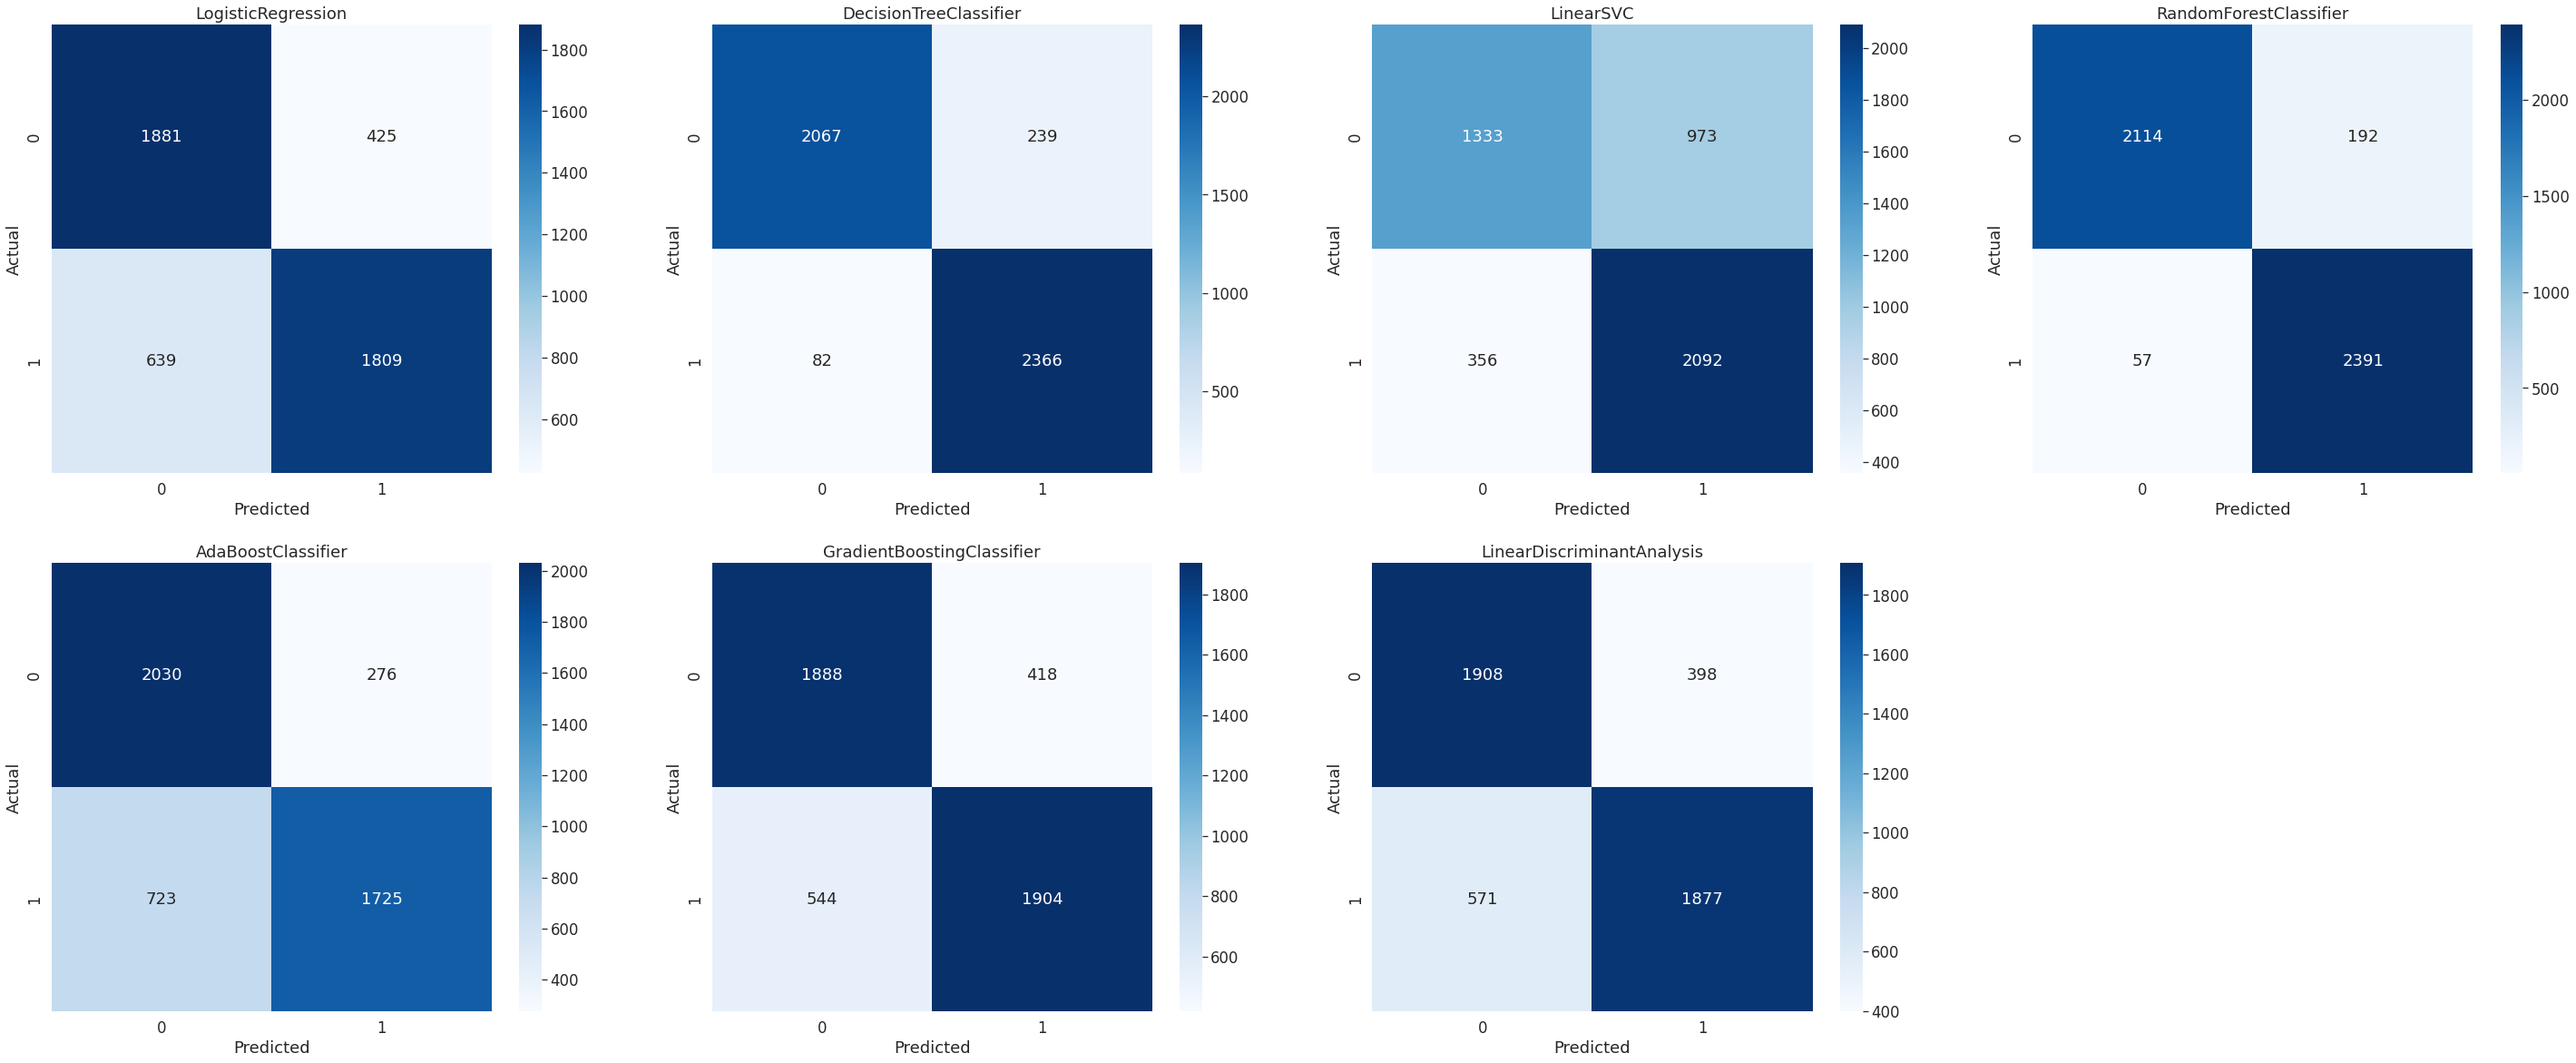

In [ ]:
# Confusion matrixes (not-normalized confusion matrix)
plt.figure(figsize=(50,20))
sns.set(font_scale=1.5)

for i in range(len(classifiers)):
    plt.subplot(2,4,i+1) #adjust this acourding to the number of algorithms
    sns.heatmap(cnfm[i], annot=True, fmt="d",cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(clf_name[i])

In [ ]:
# Search grid for optimal parameters

DT_param = {"max_depth": [2,3,8,10],
            "max_features": [0.3, 0.7, 1],
            "min_samples_split": [2, 3, 10],
            "min_samples_leaf": [1, 3, 10],
            "criterion": ["gini"]}

RF_param = {"max_depth": [10,12,14,16],
            "max_features": [0.3, 0.7, 1],
            "min_samples_split": [2, 3, 10],
            "min_samples_leaf": [1, 3, 10],
            "bootstrap": [True],
            "n_estimators" :[10,50],
            "criterion": ["gini"]}

#using 4 n_jobs to make processing faster
DTgs = GridSearchCV(DecisionTreeClassifier(), param_grid=DT_param, cv=kfold, n_jobs=4, scoring="accuracy", verbose = 1)
RFgs = GridSearchCV(RandomForestClassifier(), param_grid=RF_param, cv=kfold, n_jobs=4, scoring="accuracy", verbose = 1)

models = [DTgs, RFgs]

gs_model = []
score = []

for model in models:
    model.fit(x_train, y_train)
    gs_model.append(model.best_estimator_)
    score.append(model.best_score_)


# scores without gridsearch
print("score without GridSearchCV: ", round(cv_acc[1], 3), round(cv_acc[3], 3))
# scores with gridsearch
print("score with GridSearchCV: ", round(score[0], 3), round(score[1], 3))

Fitting 50 folds for each of 108 candidates, totalling 5400 fits
Fitting 50 folds for each of 216 candidates, totalling 10800 fits


In [ ]:
# Check for correlation between models: Make a correlation graph
plt.figure(figsize=(15,8))
sns.heatmap(model_results.drop("term_deposit", axis=1).corr(),annot=True)
plt.title("Correlation between models")

In [ ]:
# Do model ensembling
'''
best_model = VotingClassifier(estimators=[('dt', gs_model[0]), ('rf', gs_model[1])], 
                              voting='soft', n_jobs=4)
best_model.fit(x_train,y_train)
print(accuracy_score(y_test,best_model.predict(x_test)))
'''